# National Median Classification Model

The purpose of this notebook is to create a classification model to predict whether or not a city's suicide rate is bigger than the national median of rates.

Cities whose suicide rate is less than or equal to the national median are labeled 0, and cities whose suicide rate is greater than the national median are labeled 1.

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located.

---

Import libraries

In [1]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pickle
import joblib

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../../"

In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

all_models_scores = {}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [3]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [4]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    year_df = suicide[[col_year_suicide, "MUNCOD"]].copy()
    
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
    year_df["TARGET"] = (year_df[col_year_suicide] > year_df[col_year_suicide].median()).astype(int)
    year_df = year_df.drop(columns=col_year_suicide)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,1


Filling NaN values with zero and getting state code from MUNCOD column

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
df["UF"] = label_encoder.fit_transform(df["UF"])
df = df.drop(['MUNCOD'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET,UF
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,44.757293,40.688449,32.550759,0.0,126.134191,1,20
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0,20
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1,20
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,3.494426,0.000000,17.472132,0.0,0.000000,1,20
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.466639,0.0,2.466639,36.999581,0.000000,0.0,197.331097,1,20


In [6]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
df.to_csv("df_classification_highest_rates.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [8]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    col_year_suicide = "RATE_" + years[i+1]
    year_df = suicide[[col_year_suicide, "MUNCOD"]].copy()
    
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
    year_df["TARGET"] = (year_df[col_year_suicide] > year_df[col_year_suicide].median()).astype(int)
    year_df = year_df.drop(columns=col_year_suicide)
    train_df = pd.concat([train_df, year_df])

train_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,1


In [9]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)
train_df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
train_df.to_csv("train_data_classification_highest_rates.csv")

Getting testing data (2018)

In [11]:
percentage_valid_values = 0.8
test_df = suicide[["RATE_18", "MUNCOD"]].copy()
col_year_suicide = "RATE_18"    
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df[disease] = disease_df[col_year_disease] 
    disease_df = disease_df.drop(columns={col_year_disease})
    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(year_df.shape[1]*percentage_valid_values)
test_df = test_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
test_df["TARGET"] = (test_df[col_year_suicide] > test_df[col_year_suicide].median()).astype(int)
test_df = test_df.drop(columns=col_year_suicide)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,19.656406,23.587687,19.656406,231.945591,NaN,NaN,NaN,11.793844,NaN,...,0.000000,NaN,0.000000,NaN,55.037937,70.763062,3.931281,NaN,19.656406,0
1,110002,8.384182,13.973636,1.863152,32.605152,NaN,0.000000,NaN,1.863152,0.000000,...,0.931576,NaN,29.810424,0.0,13.042061,71.731334,3.726303,0.0,39.126182,0
3,110004,9.038833,20.337374,3.389562,42.934457,NaN,NaN,NaN,0.000000,2.259708,...,0.000000,NaN,NaN,0.0,11.298541,73.440519,1.129854,0.0,5.649271,1
8,110009,3.027551,12.110203,3.027551,6.055101,NaN,NaN,NaN,0.000000,NaN,...,9.082652,NaN,0.000000,NaN,9.082652,45.413261,39.358159,0.0,15.137754,1
9,110010,2.107437,0.000000,2.107437,14.752060,NaN,2.107437,0.0,2.107437,0.000000,...,21.074371,0.0,2.107437,NaN,21.074371,18.966934,0.000000,0.0,219.173463,1


In [12]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,110001,19.656406,23.587687,19.656406,231.945591,0.0,0.000000,0.0,11.793844,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,110002,8.384182,13.973636,1.863152,32.605152,0.0,0.000000,0.0,1.863152,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,110004,9.038833,20.337374,3.389562,42.934457,0.0,0.000000,0.0,0.000000,2.259708,...,0,0,0,1,0,0,0,0,0,0
8,110009,3.027551,12.110203,3.027551,6.055101,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
9,110010,2.107437,0.000000,2.107437,14.752060,0.0,2.107437,0.0,2.107437,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [13]:
test_df.to_csv("test_data_classification_highest_rates.csv")

# Model

In [14]:
df = pd.read_csv("df_classification_highest_rates.csv",index_col=0)
train_df = pd.read_csv("train_data_classification_highest_rates.csv", index_col=0)
test_df = pd.read_csv("test_data_classification_highest_rates.csv", index_col=0)

In [15]:
X_train = train_df.drop(columns=["TARGET"])
sc = StandardScaler()
sc_x_2018 = sc.fit(X_train)
joblib.dump(sc_x_2018, root + "Dashboard/Models/sav/sc_x_highest_rate.save")
mm = MinMaxScaler()
mm_x_2018 = mm.fit(X_train)
joblib.dump(mm_x_2018, root + "Dashboard/Models/sav/mm_x_highest_rate.save")

['../../../Dashboard/Models/sav/mm_x_highest_rate.save']

Checking the number of 0s and 1s in TARGET column

In [16]:
unique, counts = np.unique(df["TARGET"].values, return_counts=True)
dict(zip(unique, counts))

{0: 4680, 1: 4670}

Defining X and y

In [17]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

X.shape

(9350, 340)

Defining some functions

In [18]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [19]:
def sfm_feature_selector(X_train,y_train):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [20]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

In [21]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3, zero_division=0))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))
    if scores is not None:
        scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                      "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                      "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train, zero_division=0),
                      "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred, zero_division=0)}, ignore_index=True)
        return scores

In [22]:
def get_average_metrics(score):
    print("## Train")
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_score_train = get_average(scores["scores_train"])
    print("accuracy_train:", avg_accuracy_train)
    print("precision_train:", avg_score_train[0].mean())
    print("recall_train:", avg_score_train[1].mean())
    print("f1_score_train:", avg_score_train[2].mean())
    print("## Test")
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_score_test = get_average(scores["scores_test"])
    print("accuracy_test:", avg_accuracy_test)
    print("precision_test:", avg_score_test[0].mean())
    print("recall_test:", avg_score_test[1].mean())
    print("f1_score_test:", avg_score_test[2].mean())

## Naive Bayes

In [23]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_nb  = X_train.drop(columns=list(dict_uf_cod.values()))
    X_test_nb  = X_test.drop(columns=list(dict_uf_cod.values()))
    classifier  = GaussianNB()
    classifier.fit(X_train_nb,y_train);
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test_nb) 
    y_pred_train = classifier.predict(X_train_nb)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY NAIVE BAYES ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Naive Bayes"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Making predictions
# Calculating metrics
Train
[[2854  890]
 [1951 1785]]
              precision    recall  f1-score   support

           0      0.594     0.762     0.668      3744
           1      0.667     0.478     0.557      3736

    accuracy                          0.620      7480
   macro avg      0.631     0.620     0.612      7480
weighted avg      0.631     0.620     0.612      7480

Test
[[717 219]
 [525 409]]
              precision    recall  f1-score   support

           0      0.577     0.766     0.658       936
           1      0.651     0.438     0.524       934

    accuracy                          0.602      1870
   macro avg      0.614     0.602     0.591      1870
weighted avg      0.614     0.602     0.591      1870



=============== RUN 2 ===============
# Making predictions
# Calculating metrics
Train
[[2861  883]
 [1977 1759]]
              precision    recall  f1-score   support

           0      0.591     0.764

In [24]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]
X_train_nb  = X_train.drop(columns=list(dict_uf_cod.values()))
classifier  = GaussianNB()
classifier.fit(X_train_nb,y_train);

filename = root + 'Dashboard/Models/sav/naive_bayes_highest_rates.sav'
pickle.dump(classifier, open(filename, 'wb'))

## LogisticRegression

In [25]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

feature_importance_coef_list = []
feature_importance_shap_list = []

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    feature_importance_coef_list.append(pd.DataFrame({"Feature": X.columns, "Importance": classifier.coef_[0]}).sort_values(by="Importance", ascending=False))

    explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression"] = scores

final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_logistic_regression_highest_rates.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_logistic_regression_highest_rates.csv")

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2671 1073]
 [1116 2620]]
              precision    recall  f1-score   support

           0      0.705     0.713     0.709      3744
           1      0.709     0.701     0.705      3736

    accuracy                          0.707      7480
   macro avg      0.707     0.707     0.707      7480
weighted avg      0.707     0.707     0.707      7480

Test
[[652 284]
 [315 619]]
              precision    recall  f1-score   support

           0      0.674     0.697     0.685       936
           1      0.685     0.663     0.674       934

    accuracy                          0.680      1870
   macro avg      0.680     0.680     0.680      1870
weighted avg      0.680     0.680     0.680      1870

# Get Feature Importance


=============== RUN 2 ===============
# Scaling features
# Fitting the model

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)



# Making predictions
# Calculating metrics
Train
[[2676 1068]
 [1130 2606]]
              precision    recall  f1-score   support

           0      0.703     0.715     0.709      3744
           1      0.709     0.698     0.703      3736

    accuracy                          0.706      7480
   macro avg      0.706     0.706     0.706      7480
weighted avg      0.706     0.706     0.706      7480

Test
[[640 296]
 [297 637]]
              precision    recall  f1-score   support

           0      0.683     0.684     0.683       936
           1      0.683     0.682     0.682       934

    accuracy                          0.683      1870
   macro avg      0.683     0.683     0.683      1870
weighted avg      0.683     0.683     0.683      1870

# Get Feature Importance


=============== RUN 3 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2663 1081]
 [1126 2610]]
              precision    recall  f1-score   support

           0      0.703     0.711     0.707      3744
           1      0.707     0.699     0.703      3736

    accuracy                          0.705      7480
   macro avg      0.705     0.705     0.705      7480
weighted avg      0.705     0.705     0.705      7480

Test
[[637 299]
 [316 618]]
              precision    recall  f1-score   support

           0      0.668     0.681     0.674       936
           1      0.674     0.662     0.668       934

    accuracy                          0.671      1870
   macro avg      0.671     0.671     0.671      1870
weighted avg      0.671     0.671     0.671      1870

# Get Feature Importance


=============== RUN 4 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2653 1091]
 [1119 2617]]
              precision    recall  f1-score   support

           0      0.703     0.709     0.706      3744
           1      0.706     0.700     0.703      3736

    accuracy                          0.705      7480
   macro avg      0.705     0.705     0.705      7480
weighted avg      0.705     0.705     0.705      7480

Test
[[624 312]
 [313 621]]
              precision    recall  f1-score   support

           0      0.666     0.667     0.666       936
           1      0.666     0.665     0.665       934

    accuracy                          0.666      1870
   macro avg      0.666     0.666     0.666      1870
weighted avg      0.666     0.666     0.666      1870

# Get Feature Importance


=============== RUN 5 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2637 1107]
 [1105 2631]]
              precision    recall  f1-score   support

           0      0.705     0.704     0.705      3744
           1      0.704     0.704     0.704      3736

    accuracy                          0.704      7480
   macro avg      0.704     0.704     0.704      7480
weighted avg      0.704     0.704     0.704      7480

Test
[[644 292]
 [284 650]]
              precision    recall  f1-score   support

           0      0.694     0.688     0.691       936
           1      0.690     0.696     0.693       934

    accuracy                          0.692      1870
   macro avg      0.692     0.692     0.692      1870
weighted avg      0.692     0.692     0.692      1870

# Get Feature Importance


=============== SUMMARY LOGISTIC REGRESSION ===============
# Average Metrics
## Train
accuracy_train: 0.7054545454545454
precision_train: 0.7054783773280104
recall_train: 0.7054491754973554
f1_score_train: 0.705442

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# SHAP analysis


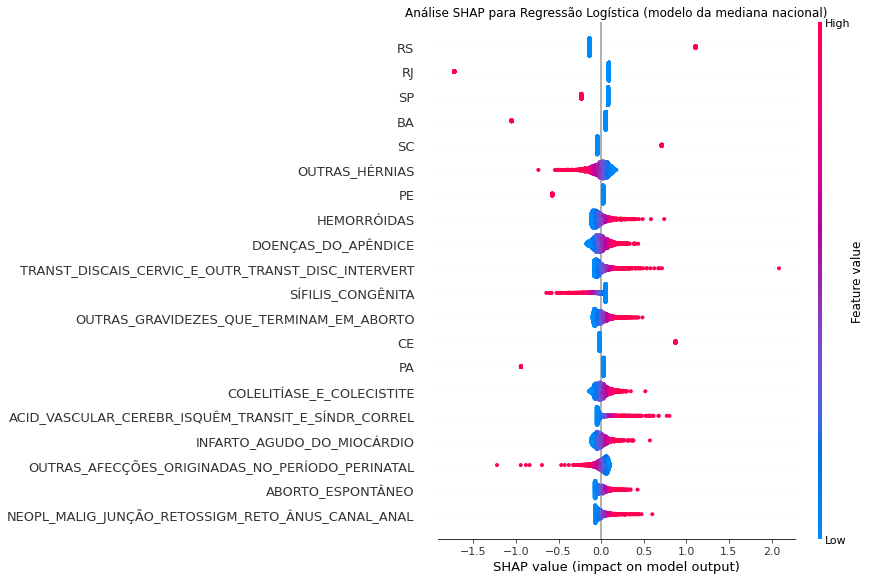

In [26]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("Análise SHAP para Regressão Logística (modelo da mediana nacional)")
plt.savefig("logistic_regression_shap_highest_rates.png", bbox_inches = "tight")

In [27]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]

X_train = mm_x_2018.transform(X_train)

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

filename = root + 'Dashboard/Models/sav/logistic_regression_highest_rates.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Random Forest
### No Scaling

In [28]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
feature_importance_shap_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test)
    
    vals= np.abs(shap_values[1]).mean(0) # se nao funcionar, tirar o [1]
    feature_importance_shap = pd.DataFrame(list(zip(X.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
    
    print("\n")
    count += 1
print("=============== SUMMARY RANDOM FOREST ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
final_feat_df.to_csv("fi_random_forest_highest_rates.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_random_forest_highest_rates.csv")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Random Forest"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
177 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2466 1278]
 [1281 2455]]
              precision    recall  f1-score   support

           0      0.658     0.659     0.658      3744
           1      0.658     0.657     0.657      3736

    accuracy                          0.658      7480
   macro avg      0.658     0.658     0.658      7480
weighted avg      0.658     0.658     0.658      7480

Test
[[615 321]
 [368 566]]
              precision    recall  f1-score   support

           0      0.626     0.657     0.641       936
           1      0.638     0.606     0.622       934

    accuracy                          0.632      1870
   macro avg      0.632     0.632     0.631      1870
weighted avg      0.632     0.632     0.631      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
182 selected feat

# SHAP analysis


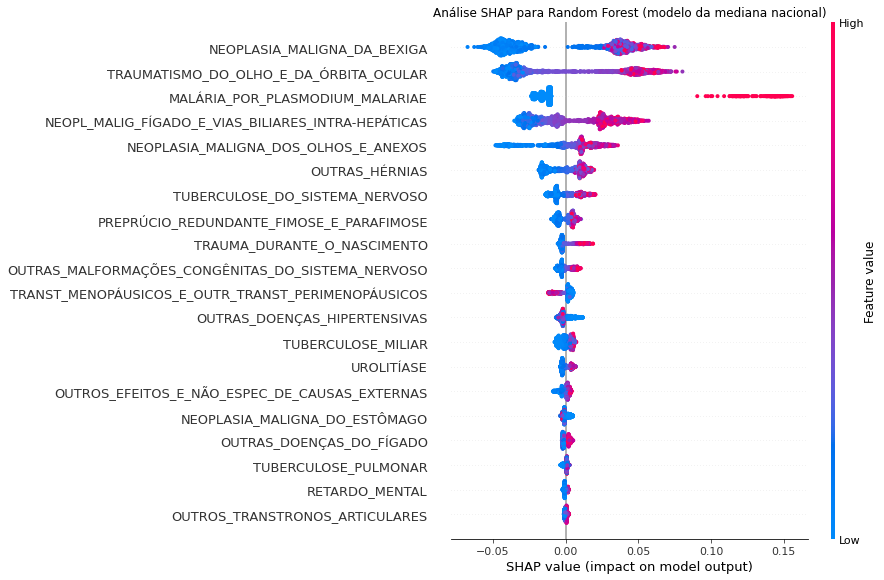

In [29]:
print("# SHAP analysis")
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, show=False)
plt.title("Análise SHAP para Random Forest (modelo da mediana nacional)")
plt.savefig("random_forest_shap_highest_rates.png", bbox_inches = "tight")

In [31]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]
print("## Chosen parameters")
print("n_estimators:", n_estimators)
print("max_depth:", max_depth)
print("min_samples_leaf:", min_samples_leaf)
print("max_features:", max_features)

classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/random_forest_highest_rates.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Chosen parameters
n_estimators: 939
max_depth: 3
min_samples_leaf: 198
max_features: 0.7131111322207875


### SHAP Individual Analysis

In [32]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["TARGET"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "TARGET"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data_for_prediction)

3685    0
Name: TARGET, dtype: int64


In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## SVM
### LinearSVC

In [36]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_coef_list = []
feature_importance_shap_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42,dual=False)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    feature_importance_coef_list.append(pd.DataFrame({"Feature": X.columns, "Importance": classifier.coef_.ravel()}).sort_values(by="Importance", ascending=False))

    explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    vals= np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame(list(zip(X.columns,vals)),columns=['Feature','Importance'])
    feature_importance_shap.sort_values(by=['Importance'],ascending=False,inplace=True)
    feature_importance_shap_list.append(feature_importance_shap)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["LinearSVC"] = scores

final_feat_df_coef = get_average_feat_importance(feature_importance_coef_list)
final_feat_df_coef.to_csv("fi_coef_linear_svc_highest_rates.csv")
final_feat_df_shap = get_average_feat_importance(feature_importance_shap_list)
final_feat_df_shap.to_csv("fi_shap_linear_svc_highest_rates.csv")

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2694 1050]
 [1105 2631]]
              precision    recall  f1-score   support

           0      0.709     0.720     0.714      3744
           1      0.715     0.704     0.709      3736

    accuracy                          0.712      7480
   macro avg      0.712     0.712     0.712      7480
weighted avg      0.712     0.712     0.712      7480

Test
[[647 289]
 [312 622]]
              precision    recall  f1-score   support

           0      0.675     0.691     0.683       936
           1      0.683     0.666     0.674       934

    accuracy                          0.679      1870
   macro avg      0.679     0.679     0.679      1870
weighted avg      0.679     0.679     0.679      1870

# Get Feature Importance


=============== RUN 2 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2683 1061]
 [1122 2614]]
              precision    recall  f1-score   support

           0      0.705     0.717     0.711      3744
           1      0.711     0.700     0.705      3736

    accuracy                          0.708      7480
   macro avg      0.708     0.708     0.708      7480
weighted avg      0.708     0.708     0.708      7480

Test
[[647 289]
 [297 637]]
              precision    recall  f1-score   support

           0      0.685     0.691     0.688       936
           1      0.688     0.682     0.685       934

    accuracy                          0.687      1870
   macro avg      0.687     0.687     0.687      1870
weighted avg      0.687     0.687     0.687      1870

# Get Feature Importance


=============== RUN 3 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2674 1070]
 [1114 2622]]
              precision    recall  f1-score   support

           0      0.706     0.714     0.710      3744
           1      0.710     0.702     0.706      3736

    accuracy                          0.708      7480
   macro avg      0.708     0.708     0.708      7480
weighted avg      0.708     0.708     0.708      7480

Test
[[639 297]
 [328 606]]
              precision    recall  f1-score   support

           0      0.661     0.683     0.672       936
           1      0.671     0.649     0.660       934

    accuracy                          0.666      1870
   macro avg      0.666     0.666     0.666      1870
weighted avg      0.666     0.666     0.666      1870

# Get Feature Importance


=============== RUN 4 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2684 1060]
 [1110 2626]]
              precision    recall  f1-score   support

           0      0.707     0.717     0.712      3744
           1      0.712     0.703     0.708      3736

    accuracy                          0.710      7480
   macro avg      0.710     0.710     0.710      7480
weighted avg      0.710     0.710     0.710      7480

Test
[[617 319]
 [316 618]]
              precision    recall  f1-score   support

           0      0.661     0.659     0.660       936
           1      0.660     0.662     0.661       934

    accuracy                          0.660      1870
   macro avg      0.660     0.660     0.660      1870
weighted avg      0.660     0.660     0.660      1870

# Get Feature Importance


=============== RUN 5 ===============
# Scaling features
# Fitting the model


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# Making predictions
# Calculating metrics
Train
[[2649 1095]
 [1084 2652]]
              precision    recall  f1-score   support

           0      0.710     0.708     0.709      3744
           1      0.708     0.710     0.709      3736

    accuracy                          0.709      7480
   macro avg      0.709     0.709     0.709      7480
weighted avg      0.709     0.709     0.709      7480

Test
[[642 294]
 [292 642]]
              precision    recall  f1-score   support

           0      0.687     0.686     0.687       936
           1      0.686     0.687     0.687       934

    accuracy                          0.687      1870
   macro avg      0.687     0.687     0.687      1870
weighted avg      0.687     0.687     0.687      1870

# Get Feature Importance


=============== SUMMARY SVM LINEAR ===============
# Average Metrics
## Train
accuracy_train: 0.709331550802139
precision_train: 0.7093641679452524
recall_train: 0.7093255275535788
f1_score_train: 0.7093161754093867

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


# SHAP analysis


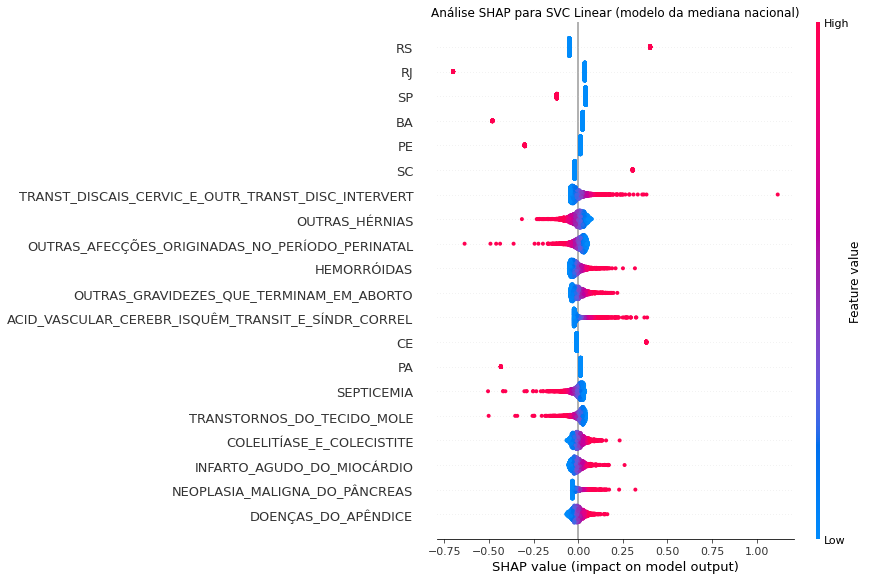

In [38]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("Análise SHAP para SVC Linear (modelo da mediana nacional)")
plt.savefig("svc_linear_shap_highest_rates.png", bbox_inches = "tight")

In [39]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]

X_train = mm_x_2018.transform(X_train)

classifier = LinearSVC(random_state=42)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_linear_highest_rates.sav'
pickle.dump(classifier, open(filename, 'wb'))

### SVC (RBF Kernel)

In [40]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm_x = MinMaxScaler().fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2638 1106]
 [ 954 2782]]
              precision    recall  f1-score   support

           0      0.734     0.705     0.719      3744
           1      0.716     0.745     0.730      3736

    accuracy                          0.725      7480
   macro avg      0.725     0.725     0.724      7480
weighted avg      0.725     0.725     0.724      7480

Test
[[641 295]
 [262 672]]
              precision    recall  f1-score   support

           0      0.710     0.685     0.697       936
           1      0.695     0.719     0.707       934

    accuracy                          0.702      1870
   macro avg      0.702     0.702     0.702      1870
weighted avg      0.702     0.702     0.702      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating met

In [41]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]

X_train = mm_x_2018.transform(X_train)

def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("## Chosen parameters")
print("C:", C)

classifier = SVC(random_state=42,C=C)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_rbf_highest_rates.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Chosen parameters
C: 1.3366880986028207


# All Models
----

Getting a summary of all training results

In [42]:
df_result_train = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_train = get_average(scores["scores_train"])
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_precision_train = avg_score_train[0].mean()
    avg_recall_train = avg_score_train[1].mean()
    avg_f1_score_train = avg_score_train[2].mean()
    df_result_train = df_result_train.append({"Model": model, 
                                  "Accuracy": avg_accuracy_train, "Precision": avg_precision_train,
                                  "Recall": avg_recall_train, "F1-Score": avg_f1_score_train},ignore_index=True)
df_result_train

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.618048,0.629280,0.617890,0.609378
1,Logistic Regression,0.705455,0.705478,0.705449,0.705442
2,Random Forest,0.656444,0.656606,0.656430,0.656340
3,LinearSVC,0.709332,0.709364,0.709326,0.709316
4,SVM RBF,0.715936,0.716962,0.715971,0.715616


Getting a summary of all testing results

In [43]:
df_result_test = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_test = get_average(scores["scores_test"])
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_precision_test = avg_score_test[0].mean()
    avg_recall_test = avg_score_test[1].mean()
    avg_f1_score_test = avg_score_test[2].mean()
    df_result_test = df_result_test.append({"Model": model, 
                                  "Accuracy": avg_accuracy_test, "Precision": avg_precision_test,
                                  "Recall": avg_recall_test, "F1-Score": avg_f1_score_test},ignore_index=True)
df_result_test

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.602781,0.612818,0.602621,0.593370
1,Logistic Regression,0.678289,0.678341,0.678284,0.678261
2,Random Forest,0.642353,0.642592,0.642336,0.642192
3,LinearSVC,0.675615,0.675674,0.675608,0.675581
4,SVM RBF,0.687059,0.688577,0.687104,0.686453


# Previsões 2018
---

Defining X and y

In [44]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]
X_test = test_df.drop(columns=["TARGET", "MUNCOD"])
y_test = test_df["TARGET"]

mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None)

# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[3317  895]
 [ 886 3317]]
              precision    recall  f1-score   support

           0      0.789     0.788     0.788      4212
           1      0.788     0.789     0.788      4203

    accuracy                          0.788      8415
   macro avg      0.788     0.788     0.788      8415
weighted avg      0.788     0.788     0.788      8415

Test
[[325 143]
 [140 327]]
              precision    recall  f1-score   support

           0      0.699     0.694     0.697       468
           1      0.696     0.700     0.698       467

    accuracy                          0.697       935
   macro avg      0.697     0.697     0.697       935
weighted avg      0.697     0.697     0.697       935



In [46]:
gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_1_correct = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]

mun_risk_ids_pred_0 = test_df[y_pred == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true_0 = test_df[y_test == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_0_correct = [x for x in mun_risk_ids_pred_0 if x in mun_risk_ids_true_0]

mun_risk_ids = mun_risk_ids_1_correct + mun_risk_ids_0_correct
mun_risk_ids_wrong = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true] + [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [47]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

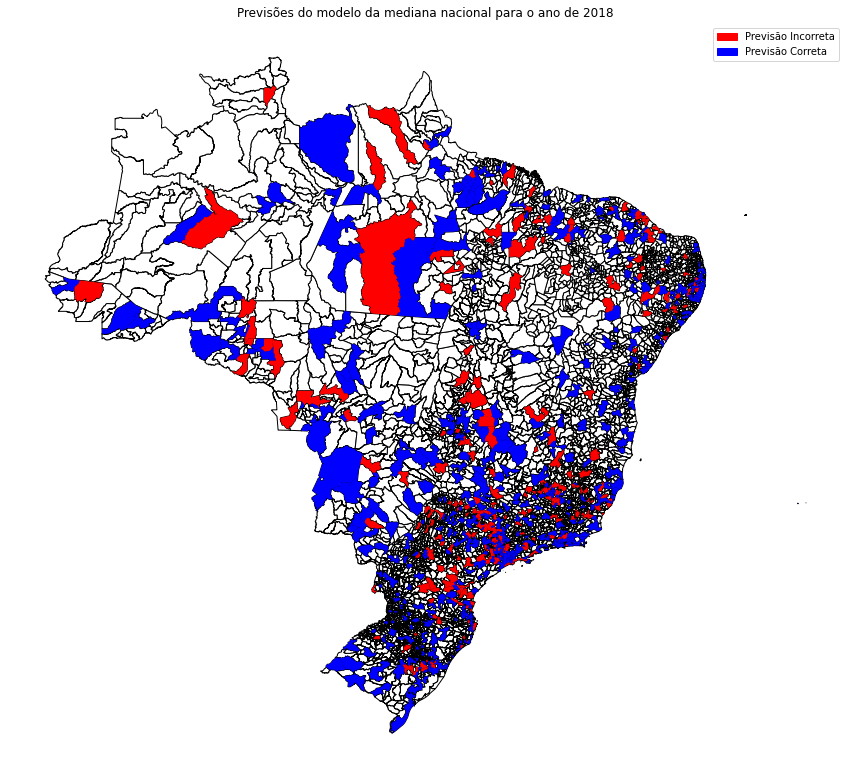

In [48]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="blue")

gd_risk_wrong = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_wrong)]
plot_risk_wrong = gd_risk_wrong.plot(ax=ax, color="red")

blue_patch = mpatches.Patch(color='blue', label='Previsão Correta')
red_patch = mpatches.Patch(color='red', label='Previsão Incorreta')
plt.title("Previsões do modelo da mediana nacional para o ano de 2018")
plt.legend(handles=[red_patch,blue_patch])
plt.axis('off')
plt.savefig("previsoes_mediana_nacional.png")